# Setup

In [43]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from scipy.stats import randint
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, auc
import scikitplot as skplt  # search for scikit-plot
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import xgboost as xgb

# Load the training data and the test inputs
x_train = pd.read_csv('X_train.csv', index_col=0, header=[0, 1, 2])
x_train_np = np.array(x_train)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_train_np = y_train.squeeze().to_numpy()  # Make y_train a NumPy array
x_test = pd.read_csv('X_test.csv', index_col=0, header=[0, 1, 2])
x_test_np = np.array(x_test)

x_train_flat_columns = ['_'.join(col).strip() for col in x_train.columns.values]
x_train.columns = x_train_flat_columns

x_test_flat_columns = ['_'.join(col).strip() for col in x_test.columns.values]
x_test.columns = x_train_flat_columns
# Prepare data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_np.ravel())

# Split training data into training and temporary validation sets
X_train, X_temp, Y_train, Y_temp = train_test_split(x_train, y_train_encoded, test_size=0.4, random_state=42)

# Split the temporary validation set into validation and fake test set
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_real_test_scaled = scaler.transform(x_test)  # real test set we don't have labels for


def calculate_test_accuracy(predictions):
    print(f"Pseudo Test Set accuracy: {accuracy_score(Y_test, predictions):.2f}")


def calculate_training_accuracy(predictions):
    print(f"Training Set accuracy: {accuracy_score(Y_train, predictions):.2f}")


def split_features_by_type(X, feature_structure):
    """
    Splits the dataset into subsets based on the feature structure provided.

    :param X: numpy array, the dataset to be split (features only)
    :param feature_structure: dict, keys are feature names and values are the number of features of that type
    :return: dict of feature subsets
    """
    feature_subsets = {}
    start_idx = 0
    
    for feature_name, feature_count in feature_structure.items():
        end_idx = start_idx + feature_count
        feature_subsets[feature_name] = X[:, start_idx:end_idx]
        start_idx = end_idx
    
    return feature_subsets

# Define the structure of your features based on the information you've provided
feature_structure = {
    'chroma_cens': 84,
    'chroma_cqt': 84,
    'chroma_stft': 84,
    'mfcc': 140,
    'rmse': 7,
    'spectral_bandwidth': 7,
    'spectral_centroid': 7,
    'spectral_contrast': 49,
    'spectral_rolloff': 7,
    'tonnetz': 42,
    'zcr': 7
}

# Example usage with a hypothetical dataset X_train_scaled
# This would be your preprocessed and scaled training data as a NumPy array
train_feature_subsets = split_features_by_type(X_train_scaled, feature_structure)
val_feature_subsets = split_features_by_type(X_val_scaled, feature_structure)
test_feature_subsets = split_features_by_type(X_test_scaled, feature_structure)

## KNN

### KNN Bagging

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

# Number of base estimators
n_estimators = 10  # You can experiment with this number

# Create a BaggingClassifier with KNN as base estimators
bagging_clf = BaggingClassifier(
    estimator=KNeighborsClassifier(n_neighbors=1), 
    n_estimators=n_estimators, 
    max_samples=1.0 / n_estimators, 
    bootstrap=True, 
    random_state=42,
    n_jobs=-1  # Use all cores
)

# Fit the BaggingClassifier
bagging_clf.fit(X_train_scaled, Y_train)
# training predictions
trainpreds = bagging_clf.predict(X_train_scaled)
# test predictions
testpreds = bagging_clf.predict(X_test_scaled)

print(calculate_training_accuracy(trainpreds))
print(calculate_test_accuracy(testpreds))

Training Set accuracy: 0.52
Pseudo Test Set accuracy: 0.40


### KNN  Ensembling

In [11]:
from sklearn.neighbors import KNeighborsClassifier
# Define a range of k values
k_values = [1, 8, 64]

# Train a KNN model for each k
knn_models = [KNeighborsClassifier(n_neighbors=k).fit(X_train_scaled, Y_train) for k in k_values]

# Predict on the trainig set with each model
train_predictions = [model.predict(X_train_scaled) for model in knn_models]

# Predict on the trainig set with each model
test_predictions = [model.predict(X_test_scaled) for model in knn_models]

# Combine predictions: Take the mode of predictions across the different models
combined_train_predictions = mode(train_predictions, axis=0)[0][0]

combined_test_predictions = mode(test_predictions, axis=0)[0][0]

# Evaluate accuracy
val_accuracy = np.mean(combined_train_predictions == Y_train)
print(f"Train accuracy with combined KNN models: {val_accuracy}")

val_accuracy = np.mean(combined_test_predictions == Y_val)
print(f"Test accuracy with combined KNN models: {val_accuracy}")

Train accuracy with combined KNN models: 0.1238888888888889
Test accuracy with combined KNN models: 0.13


## KNN on feature subsets, Majority Voting

In [16]:
from sklearn.neighbors import KNeighborsClassifier

# Dictionary to store the trained KNN models for each feature subset
knn_models = {}

# Train a KNN model for each feature subset
from sklearn.model_selection import cross_val_score

# Dictionary to store the best KNN models for each feature subset
best_knn_models = {}

# Train a KNN model for each feature subset and find the best k using cross-validation
for feature_name, X_subset in train_feature_subsets.items():
    best_score = 0
    best_k = 1
    # Try different values of k
    for k in range(1, 16):  # Let's try k from 1 to 15 as an example
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_subset, Y_train, cv=5)
        mean_score = scores.mean()
        if mean_score > best_score:
            best_score = mean_score
            best_k = k

    # Train a new KNN model on the full training set with the best k
    best_knn = KNeighborsClassifier(n_neighbors=best_k)
    best_knn.fit(X_subset, Y_train)
    best_knn_models[feature_name] = best_knn
    print(f"Best K for {feature_name} features: {best_k} with cross-validation score: {best_score}")

# Now best_knn_models dictionary contains the best KNN model for each feature subset
# Gather predictions from all models on the validation set
test_predictions = []
for feature_name, model in best_knn_models.items():
    # Ensure that we predict on the correct feature subset
    X_val_subset = val_feature_subsets[feature_name]
    predictions = model.predict(X_val_subset)
    val_predictions.append(predictions)

# Combine predictions using majority voting
combined_val_predictions = mode(val_predictions, axis=0).mode

# Calculate accuracy or any other metric based on the combined predictions
val_accuracy = np.mean(combined_val_predictions.ravel() == Y_val)
print(f"Validation accuracy with combined KNN models: {val_accuracy}")



Best K for chroma_cens features: 9 with cross-validation score: 0.2663888888888889
Best K for chroma_cqt features: 13 with cross-validation score: 0.27361111111111114
Best K for chroma_stft features: 13 with cross-validation score: 0.30194444444444446
Best K for mfcc features: 15 with cross-validation score: 0.46611111111111103
Best K for rmse features: 15 with cross-validation score: 0.23555555555555552
Best K for spectral_bandwidth features: 15 with cross-validation score: 0.29083333333333333
Best K for spectral_centroid features: 11 with cross-validation score: 0.32166666666666666
Best K for spectral_contrast features: 12 with cross-validation score: 0.40861111111111115
Best K for spectral_rolloff features: 12 with cross-validation score: 0.3061111111111111
Best K for tonnetz features: 6 with cross-validation score: 0.2725000000000001
Best K for zcr features: 14 with cross-validation score: 0.30583333333333335
Validation accuracy with combined KNN models: 0.4725


## KNN on feature subsets, Majority Voting

In [23]:
# Calculate the validation accuracy for each feature subset and use it as weight for voting
weights = []
for feature_name, model in best_knn_models.items():
    X_val_subset = val_feature_subsets[feature_name]
    val_accuracy = model.score(X_val_subset, Y_val)
    weights.append(val_accuracy)
    # print(f"Validation accuracy for {feature_name} features: {val_accuracy}")

# Normalize weights so they sum up to 1
weights = np.array(weights) / np.sum(weights)

# Predict on the train set with each model and weight the predictions
weighted_train_predictions = np.zeros((X_train_scaled.shape[0], len(np.unique(Y_train))), dtype=float)

for i, (feature_name, model) in enumerate(best_knn_models.items()):
    X_train_subset = train_feature_subsets[feature_name]
    train_predictions = model.predict_proba(X_train_subset)
    weighted_preds = train_predictions * weights[i]
    weighted_train_predictions += weighted_preds
    
    
# Predict on the test set with each model and weight the predictions
weighted_test_predictions = np.zeros((X_test_scaled.shape[0], len(np.unique(Y_test))), dtype=float)

for i, (feature_name, model) in enumerate(best_knn_models.items()):
    X_test_subset = test_feature_subsets[feature_name]
    predictions = model.predict_proba(X_test_subset)
    weighted_preds = predictions * weights[i]
    weighted_test_predictions += weighted_preds

# Combine weighted predictions by taking the argmax to get final predictions
combined_train_predictions = np.argmax(weighted_train_predictions, axis=1)
combined_test_predictions = np.argmax(weighted_test_predictions, axis=1)

calculate_training_accuracy(combined_train_predictions)
calculate_test_accuracy(combined_test_predictions)

Training Set accuracy: 0.76
Pseudo Test Set accuracy: 0.52


### KNN optimizing for Distance Metrics on feature subsets

In [26]:
# Define a list of distance metrics to try
distance_metrics = ['euclidean', 'manhattan', 'minkowski']

# Define a range of k values to try
k_values = range(1, 16)  # Example: trying k from 1 to 15

# Dictionary to store the best KNN model for each feature subset
best_knn_models_dm_k = {}

# Dictionary to store the best combination of distance metric and k for each feature subset
best_combinations = {}

for feature_name, X_subset in train_feature_subsets.items():
    best_score = 0
    best_combination = {'metric': '', 'k': 0}
    # Iterate over each distance metric
    for metric in distance_metrics:
        # Iterate over each value of k
        for k in k_values:
            # Create a KNN model with the current metric and k
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            # Perform cross-validation and compute the mean score
            scores = cross_val_score(knn, X_subset, Y_train, cv=5)
            mean_score = scores.mean()
            # Update the best combination if the current model performs better
            if mean_score > best_score:
                best_score = mean_score
                best_combination['metric'] = metric
                best_combination['k'] = k
    
    # Once the best combination is found, retrain the model on the full training set
    best_knn = KNeighborsClassifier(n_neighbors=best_combination['k'], metric=best_combination['metric'])
    best_knn.fit(X_subset, Y_train)
    best_knn_models_dm_k[feature_name] = best_knn
    best_combinations[feature_name] = best_combination
    # print(f"Best combination for {feature_name} features: k={best_combination['k']}, metric={best_combination['metric']} with cross-validation score: {best_score:.2f}")
    # Calculate the validation accuracy for each feature subset and use it as weight for voting
weights = []
for feature_name, model in best_knn_models_dm_k.items():
    X_val_subset = val_feature_subsets[feature_name]
    val_accuracy = model.score(X_val_subset, Y_val)
    weights.append(val_accuracy)
    # print(f"Validation accuracy for {feature_name} features: {val_accuracy:.2f}")

# Normalize weights so they sum up to 1
weights = np.array(weights) / np.sum(weights)

# Split the test set using the same feature structure

# Predict on the train set with each model and weight the predictions
weighted_train_predictions = np.zeros((X_train_scaled.shape[0], 8), dtype=float)

for i, (feature_name, model) in enumerate(best_knn_models_dm_k.items()):
    X_train_subset = train_feature_subsets[feature_name]
    predictions = model.predict_proba(X_train_subset)
    weighted_predictions = predictions * weights[i]
    weighted_train_predictions += weighted_predictions
    
# Predict on the test set with each model and weight the predictions
weighted_test_predictions = np.zeros((X_test_scaled.shape[0], 8), dtype=float)

for i, (feature_name, model) in enumerate(best_knn_models_dm_k.items()):
    X_test_subset = test_feature_subsets[feature_name]
    predictions = model.predict_proba(X_test_subset)
    weighted_predictions = predictions * weights[i]
    weighted_test_predictions += weighted_predictions

# Combine weighted predictions by taking the argmax to get final predictions
combined_train_predictions = np.argmax(weighted_train_predictions, axis=1)
combined_test_predictions = np.argmax(weighted_test_predictions, axis=1)

# Calculate accuracy based on the combined weighted predictions
calculate_training_accuracy(combined_train_predictions)
calculate_test_accuracy(combined_test_predictions)

Training Set accuracy: 0.74
Pseudo Test Set accuracy: 0.51


### Logistic Reg as Meta Learner on KNN on feature subsets

In [30]:
# Generate meta-features for the validation set
val_meta_features = np.column_stack([
    model.predict_proba(val_feature_subsets[feature_name]) for feature_name, model in best_knn_models_dm_k.items()
])

from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(val_meta_features, Y_val)  # Assuming Y_val is the validation set labels

# Generate meta-features for the train set
train_meta_features = np.column_stack([
    model.predict_proba(train_feature_subsets[feature_name]) for feature_name, model in best_knn_models_dm_k.items()
])

# Generate meta-features for the test set
test_meta_features = np.column_stack([
    model.predict_proba(test_feature_subsets[feature_name]) for feature_name, model in best_knn_models_dm_k.items()
])

# Final predictions using the meta-learner
train_predictions = meta_model.predict(train_meta_features)
test_predictions = meta_model.predict(test_meta_features)

calculate_training_accuracy(train_predictions)
calculate_test_accuracy(test_predictions)

Training Set accuracy: 0.71
Pseudo Test Set accuracy: 0.55


# Best Model per Feature Subset

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # For SVM with RBF kernel
from xgboost import XGBClassifier  # For XGBoost
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming `feature_subsets`, `X_train`, `Y_train`, `X_val`, `Y_val`, `X_test`, `Y_test`, `val_feature_subsets`, and `test_feature_subsets` are already defined

best_models = {}
model_accuracies = {}  # To store the best accuracy for each feature subset

for feature_name, X_train_subset in train_feature_subsets.items():
    best_model = None
    best_accuracy = 0
    X_val_subset = val_feature_subsets[feature_name]

    models = {
        'KNN': KNeighborsClassifier(),
        'RF': RandomForestClassifier(random_state=42),
        'LR': LogisticRegression(random_state=42, max_iter=1000),
        'SVM': SVC(probability=True, kernel='rbf', random_state=42),  # SVM with RBF kernel
        'XGB': XGBClassifier(eval_metric='mlogloss', random_state=42)  # XGBoost
    }

    for model_name, model in models.items():
        model.fit(X_train_subset, Y_train)
        accuracy = model.score(X_val_subset, Y_val)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = (model_name, model)

    best_models[feature_name] = best_model
    model_accuracies[feature_name] = best_accuracy  # Store the best accuracy

# Print out the best model and its accuracy for each feature subset
for feature_name, (model_name, _) in best_models.items():
    accuracy = model_accuracies[feature_name]
    print(f"Feature: {feature_name}, Best Model: {model_name}, Accuracy: {accuracy:.2f}")

# Ensemble selected models for final prediction
ensemble_predictions = np.zeros((len(Y_test), len(np.unique(Y_train))))

for feature_name, (model_type, model) in best_models.items():
    X_test_subset = test_feature_subsets[feature_name]
    if hasattr(model, "predict_proba"):
        predictions = model.predict_proba(X_test_subset)
    else:  # For models like SVM that might not support predict_proba by default
        predictions = model.decision_function(X_test_subset)
        # Normalize SVM decision function output to [0, 1] for ensemble
        predictions = (predictions - predictions.min()) / (predictions.max() - predictions.min())
    ensemble_predictions += predictions

# Final ensemble prediction
final_predictions = np.argmax(ensemble_predictions, axis=1)

# Calculate and print the test accuracy
test_accuracy = accuracy_score(Y_test, final_predictions)
print(f"Test accuracy with the best model from each feature subset ensemble: {test_accuracy}")


Feature: chroma_cens, Best Model: SVM, Accuracy: 0.33
Feature: chroma_cqt, Best Model: SVM, Accuracy: 0.35
Feature: chroma_stft, Best Model: RF, Accuracy: 0.39
Feature: mfcc, Best Model: SVM, Accuracy: 0.56
Feature: rmse, Best Model: RF, Accuracy: 0.27
Feature: spectral_bandwidth, Best Model: RF, Accuracy: 0.33
Feature: spectral_centroid, Best Model: SVM, Accuracy: 0.38
Feature: spectral_contrast, Best Model: SVM, Accuracy: 0.47
Feature: spectral_rolloff, Best Model: SVM, Accuracy: 0.37
Feature: tonnetz, Best Model: XGB, Accuracy: 0.33
Feature: zcr, Best Model: SVM, Accuracy: 0.34
Test accuracy with the best model from each feature subset ensemble: 0.5683333333333334


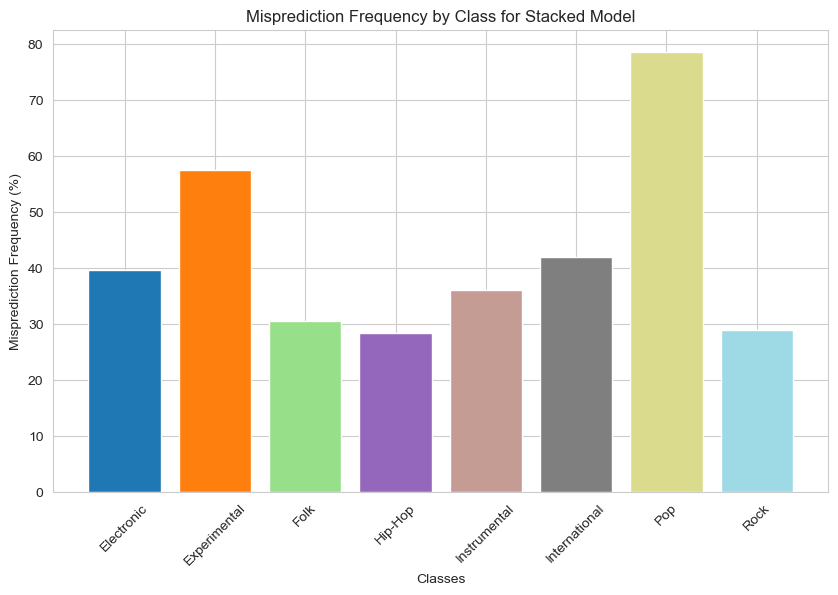

In [87]:
from collections import Counter
final_predictions_decoded = label_encoder.inverse_transform(final_predictions)
# Calculate mispredictions
mispredictions = (Y_test != final_predictions)

# Decode the true labels and the predicted labels for interpretability
y_test_decoded = label_encoder.inverse_transform(Y_test)
final_predictions_decoded = label_encoder.inverse_transform(final_predictions)

# Count the total occurrences for each class in the true test set
total_counts = Counter(y_test_decoded)

# Count mispredictions for each decoded class
mispredicted_counts = Counter(y_test_decoded[mispredictions])

# Calculate misprediction frequencies as a percentage
misprediction_frequencies = {class_label: (mispredicted_counts.get(class_label, 0) / total_counts[class_label]) * 100
                             for class_label in total_counts}

# Sort the classes by name to maintain consistent order
sorted_class_labels = sorted(total_counts.keys())

# Prepare colors, one for each class
colors = plt.cm.tab20(np.linspace(0, 1, len(sorted_class_labels)))

# Bar chart of misprediction frequencies (as percentages)
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_class_labels)), [misprediction_frequencies[class_label] for class_label in sorted_class_labels], color=colors)
plt.xlabel('Classes')
plt.ylabel('Misprediction Frequency (%)')
plt.xticks(ticks=range(len(sorted_class_labels)), labels=sorted_class_labels, rotation=45)
plt.title('Misprediction Frequency by Class for Stacked Model')
plt.show()


# Neural Nets

In [44]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.int64)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.int64)
X_real_test_tensor = torch.tensor(X_real_test_scaled, dtype=torch.float32)

# Create TensorDatasets and DataLoaders for training, validation, test sets
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [45]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [46]:
class CustomNN(nn.Module):
    def __init__(self, input_size, num_classes, num_layers=2, hidden_size=100):
        super(CustomNN, self).__init__()
        self.layers = nn.ModuleList()
        
        for i in range(num_layers):
            if i == 0:
                self.layers.append(nn.Linear(input_size, hidden_size))
            else:
                self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())

        self.output_layer = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x


In [72]:
def train_and_validate(model, train_loader, val_loader, device, optimizer, criterion, epochs=10):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = correct / total
    return val_accuracy


def evaluate_pytorch_model(model, dataloaders, device):
    model.eval()  # Set the model to evaluation mode
    performance = {}
    with torch.no_grad():
        for phase in ['train', 'val', 'test']:
            if phase not in dataloaders:
                continue
            correct, total = 0, 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = correct / total
            performance[phase + '_accuracy'] = accuracy
            print(f'Accuracy of the {model.__class__.__name__} model on the {phase} set: {accuracy:.2f}')


In [63]:
import optuna
all_models = []
def objective(trial):
    # Hyperparameters to tune
    lr = trial.suggest_float('lr', 1e-5, 1e-1)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    hidden_size = trial.suggest_int('hidden_size', 50, 500)
    
    # Model initialization
    model = CustomNN(input_size=X_train.shape[1], num_classes=len(np.unique(Y_train)),
                     num_layers=num_layers, hidden_size=hidden_size).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Train and validate
    val_accuracy = train_and_validate(model, train_loader, val_loader, device, optimizer, criterion, epochs=10)
    
    # Save the model and trial information
    all_models.append({'trial_id': trial.number, 'model': model, 'val_accuracy': val_accuracy})
    
    return val_accuracy


In [70]:
study = optuna.create_study(direction='maximize', study_name='MLP')
study.optimize(objective, n_trials=30)  # Adjust the number of trials as needed

print("Best trial:")
trial = study.best_trial

print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Find the best model based on validation accuracy
best_model_info = max(all_models, key=lambda x: x['val_accuracy'])
best_model = best_model_info['model']



[I 2024-03-16 18:41:38,943] A new study created in memory with name: MLP
[I 2024-03-16 18:41:41,776] Trial 0 finished with value: 0.5033333333333333 and parameters: {'lr': 0.020109521612810172, 'num_layers': 1, 'hidden_size': 355}. Best is trial 0 with value: 0.5033333333333333.
[I 2024-03-16 18:41:44,509] Trial 1 finished with value: 0.48083333333333333 and parameters: {'lr': 0.07460004650272418, 'num_layers': 1, 'hidden_size': 287}. Best is trial 0 with value: 0.5033333333333333.
[I 2024-03-16 18:41:47,762] Trial 2 finished with value: 0.1175 and parameters: {'lr': 0.040083907602066114, 'num_layers': 2, 'hidden_size': 258}. Best is trial 0 with value: 0.5033333333333333.
[I 2024-03-16 18:41:51,989] Trial 3 finished with value: 0.11833333333333333 and parameters: {'lr': 0.0617450100249225, 'num_layers': 3, 'hidden_size': 481}. Best is trial 0 with value: 0.5033333333333333.
[I 2024-03-16 18:41:56,032] Trial 4 finished with value: 0.4791666666666667 and parameters: {'lr': 0.01874776009

Best trial:
Value: 0.5783333333333334
Params: 
    lr: 0.0008945125158441643
    num_layers: 1
    hidden_size: 57


In [73]:
# Test the best model
evaluate_pytorch_model(best_model, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)

Accuracy of the CustomNN model on the train set: 0.82
Accuracy of the CustomNN model on the val set: 0.58
Accuracy of the CustomNN model on the test set: 0.57


## More complex type of MLP that includes batch norm and dropout layers, weight decay

In [74]:
class AdvancedCustomNN(nn.Module):
    def __init__(self, input_size, num_classes, num_layers=2, hidden_size=100, dropout_rate=0.0, use_batch_norm=False):
        super(AdvancedCustomNN, self).__init__()
        layers = []
        
        for i in range(num_layers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
                
        layers.append(nn.Linear(hidden_size, num_classes))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)


In [75]:
all_advanced_mlps = []
def advanced_objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_layers = trial.suggest_int('num_layers', 2, 8)
    hidden_size = trial.suggest_int('hidden_size', 50, 600)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    
    model = AdvancedCustomNN(input_size=X_train.shape[1], num_classes=len(np.unique(Y_train)),
                             num_layers=num_layers, hidden_size=hidden_size,
                             dropout_rate=dropout_rate, use_batch_norm=use_batch_norm).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    val_accuracy = train_and_validate(model, train_loader, val_loader, device, optimizer, criterion, epochs=10)
    # Save the model and trial information
    all_advanced_mlps.append({'trial_id': trial.number, 'model': model, 'val_accuracy': val_accuracy})
    
    return val_accuracy


In [76]:
study = optuna.create_study(direction='maximize', study_name="MLP Advanced")
study.optimize(advanced_objective, n_trials=20)  # Adjust n_trials based on computational resources

print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-03-16 18:46:22,416] A new study created in memory with name: MLP Advanced
[I 2024-03-16 18:46:31,081] Trial 0 finished with value: 0.55 and parameters: {'lr': 0.0004477447858678547, 'num_layers': 4, 'hidden_size': 142, 'dropout_rate': 0.05321709666025598, 'use_batch_norm': True, 'weight_decay': 0.06068257451135976}. Best is trial 0 with value: 0.55.
[I 2024-03-16 18:46:39,182] Trial 1 finished with value: 0.1175 and parameters: {'lr': 0.011182237003139098, 'num_layers': 7, 'hidden_size': 287, 'dropout_rate': 0.32130625886432435, 'use_batch_norm': False, 'weight_decay': 0.0009658820411423538}. Best is trial 0 with value: 0.55.
[I 2024-03-16 18:46:44,764] Trial 2 finished with value: 0.1175 and parameters: {'lr': 0.09348222659485882, 'num_layers': 4, 'hidden_size': 228, 'dropout_rate': 0.05471452014685407, 'use_batch_norm': False, 'weight_decay': 0.00027937192004457464}. Best is trial 0 with value: 0.55.
[I 2024-03-16 18:46:50,424] Trial 3 finished with value: 0.11583333333333333

Best trial:
Value: 0.5666666666666667
Params: 
    lr: 0.000720697356126061
    num_layers: 6
    hidden_size: 221
    dropout_rate: 0.2685306611336606
    use_batch_norm: True
    weight_decay: 0.0027021450379733246


In [77]:
# Find the best model based on validation accuracy
best_adv_mlp_info = max(all_advanced_mlps, key=lambda x: x['val_accuracy'])
best_adv_mlp = best_adv_mlp_info['model']

evaluate_pytorch_model(best_adv_mlp, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)

Accuracy of the AdvancedCustomNN model on the train set: 0.79
Accuracy of the AdvancedCustomNN model on the val set: 0.57
Accuracy of the AdvancedCustomNN model on the test set: 0.57


## Manually experiment with MLP Architectures

In [78]:
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F
def train_and_validate_with_plot(model, train_loader, val_loader, device, optimizer, criterion, epochs=10):
    # Lists to keep track of losses and timing
    train_losses = []
    val_losses = []
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # Calculate and store the average training loss
        train_losses.append(running_loss / len(train_loader))
        running_loss = 0.0  # Reset running loss for validation
        
        # Validation phase
        model.eval()  # Set the model to evaluation mode
        total, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Corrected to use labels
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            # Calculate and store the average validation loss
            val_losses.append(running_loss / len(val_loader))

    end_time = time.time()
    elapsed_time = (end_time - start_time) / 60  # Time in minutes
    
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_accuracy = correct / total
    print(f"Training completed in: {elapsed_time:.2f} minutes")
    return val_accuracy


In [79]:
class ManualNN(nn.Module):
    def __init__(self, input_size=518, num_classes=8, dropout_rate=0.3, hidden_units=[256, 128, 64, 32]):
        super(ManualNN, self).__init__()

        # Define the layers
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(hidden_units[i]) for i in range(len(hidden_units))])

        self.input_layer = nn.Linear(input_size, hidden_units[0])
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_units[i], hidden_units[i+1]) for i in range(len(hidden_units)-1)])
        self.output_layer = nn.Linear(hidden_units[-1], num_classes)

    def forward(self, x):
        # Forward pass through each layer
        x = self.bn_layers[0](self.input_layer(x))
        x = F.relu(x)
        for i, layer in enumerate(self.hidden_layers):
            x = self.bn_layers[i+1](layer(x))
            x = F.relu(x)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [80]:
def train_and_validate_with_plot_es(model, train_loader, val_loader, device, optimizer, criterion, epochs=10, patience=5):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        running_loss = 0.0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        average_val_loss = running_loss / len(val_loader)
        val_losses.append(average_val_loss)

        # Early Stopping
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return model, train_losses, val_losses


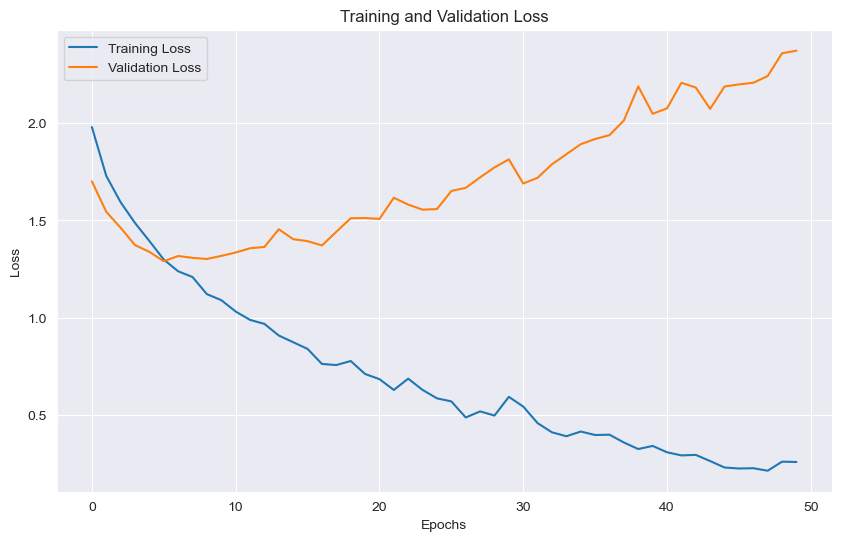

Training completed in: 0.47 minutes
Accuracy of the ManualNN model on the train set: 0.99
Accuracy of the ManualNN model on the val set: 0.53
Accuracy of the ManualNN model on the test set: 0.55


In [82]:
# Instantiate
# NN = ManualNN(hidden_units=[2056] * 4 + [1028] * 4 + [512]*4 + [256]*4 + [128]*4 + [64]*4 + [32,16], dropout_rate=0.4).to(device)
NN = ManualNN(dropout_rate=0.4).to(device)
# Define optimizer and loss function
# optimizer = torch.optim.Adam(NN.parameters(), lr=0.001)
optimizer = torch.optim.SGD(NN.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and validate the model
epochs = 50
val_accuracy = train_and_validate_with_plot(NN, train_loader, val_loader, device, optimizer, criterion, epochs)
evaluate_pytorch_model(NN, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)

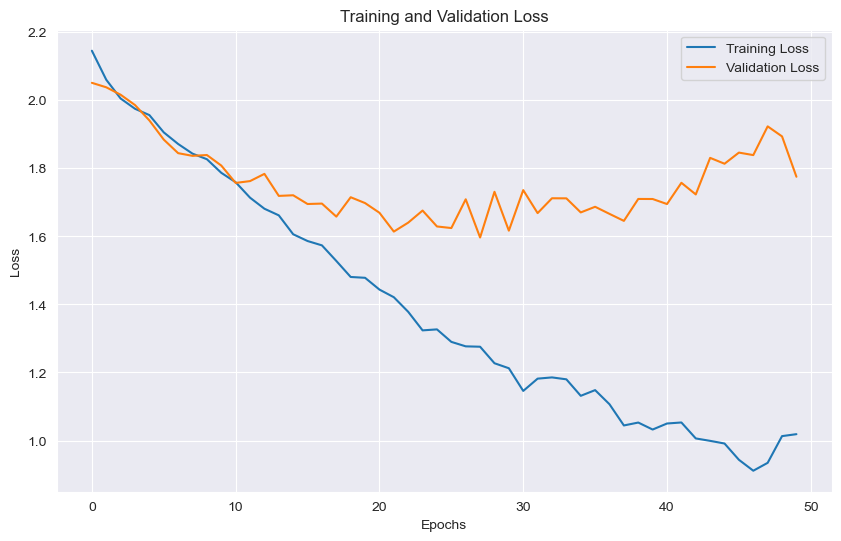

Training completed in: 0.95 minutes
Accuracy of the ManualNN model on the train set: 0.76
Accuracy of the ManualNN model on the val set: 0.46
Accuracy of the ManualNN model on the test set: 0.47


In [83]:
# Instantiate
NN = ManualNN(hidden_units=[2056] * 1 + [1028] * 0 + [512]*1 + [256]*4 + [128]*1 + [64]*1 + [32,16], dropout_rate=0.4).to(device)
# NN = ManualNN(dropout_rate=0.4).to(device)
# Define optimizer and loss function
# optimizer = torch.optim.Adam(NN.parameters(), lr=0.001)
optimizer = torch.optim.SGD(NN.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train and validate the model
epochs = 50
val_accuracy = train_and_validate_with_plot(NN, train_loader, val_loader, device, optimizer, criterion, epochs)
evaluate_pytorch_model(NN, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)

In [ ]:
# Try varying batch sizes:
bs = 64
train_loader_vbs = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader_vbs = DataLoader(val_dataset, batch_size=bs, shuffle=False)
test_loader_vbs = DataLoader(test_dataset, batch_size=bs, shuffle=False)
# Instantiate #10360 works fairly well
NN = ManualNN(hidden_units=[268324] + [33540]*0 + [256]*0 + [128] + [64]*1 + [32]* 1 + [16], dropout_rate=0.5).to(device)
# Define optimizer and loss function
# optimizer = torch.optim.Adam(NN.parameters(), lr=0.001)
optimizer = torch.optim.SGD(NN.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSE()

# Train and evaluate the model
epochs = 500
patience = 50
val_acc = train_and_validate_with_plot_es(NN, train_loader_vbs, val_loader_vbs, device, optimizer, criterion, epochs, patience)
evaluate_pytorch_model(NN, dataloaders={'train': train_loader, 'val': val_loader, 'test': test_loader}, device=device)